# Setup

In [1]:
import sys
sys.path.append('../src')
sys.path.append('../../EP2')

In [2]:
from hydra import compose, initialize
from omegaconf import DictConfig, open_dict
import pyrootutils

def get_cfg():
    with initialize(version_base="1.2", config_path="../../EP2/configs"):
        cfg = compose(config_name="train.yaml", return_hydra_config=True, overrides=[])
        with open_dict(cfg):
            cfg.paths.root_dir = str(pyrootutils.find_root())
            cfg.trainer.max_epochs = 1
            cfg.trainer.limit_train_batches = 0.01
            cfg.trainer.limit_val_batches = 0.1
            cfg.trainer.limit_test_batches = 0.1
            cfg.trainer.accelerator = "cpu"
            cfg.trainer.devices = 1
            cfg.datamodule.num_workers = 0
            cfg.datamodule.pin_memory = False
            cfg.datamodule.batch_size = 1
            cfg.extras.print_config = False
            cfg.extras.enforce_tags = False
            cfg.logger = None
            
        return cfg

In [7]:
import json

def print_pretty_json(json_obj):
    print(json.dumps(json_obj, indent=4, sort_keys=True))

# Compare solving method

$\bf -f=J(X)\Delta X$

$\bf f=B, X=\tilde V, \mathbf J = \frac{\partial \mathbf {\tilde L}}{\partial \mathbf{\tilde V}}$

Between 

i) add $i(V)$ to $B$

ii) add $\text{diag}(a(V))$ to $J$

In [ ]:
from src.models.components.E_minimizer import _stepsolve2



# Newton solver 1 vs 2

In [4]:
from src.models.components.eqprop_backbone import AnalogEP, AnalogEP2
import torch

/root/miniconda3/envs/EP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
x, y = torch.rand(1, 784).clamp_min(0.01), torch.randint(0, 10, (1,))

### 2

In [12]:
ep2 = AnalogEP2()

In [20]:
from src.utils.eqprop import init_params
from functools import partial

ep2.model.apply(partial(init_params, min=1e-5, max=1))

Sequential(
  (lin1): Linear(in_features=784, out_features=256, bias=False)
  (last): Linear(in_features=256, out_features=10, bias=False)
)

In [29]:
%%timeit
ep2.forward(x)

2.66 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
list(ep2.model.named_buffers())

[('ypred',
  tensor([[-8.4466e-28,  4.5881e-41, -8.4466e-28,  4.5881e-41,  0.0000e+00,
            0.0000e+00,  2.8026e-45,  0.0000e+00,  0.0000e+00,  1.4013e-45]])),
 ('lin1.free_node',
  tensor([[0.5059, 0.5046, 0.5002, 0.5033, 0.5032, 0.5045, 0.5036, 0.5091, 0.4985,
           0.5060, 0.5164, 0.4977, 0.5138, 0.5130, 0.5056, 0.5074, 0.5005, 0.5015,
           0.4993, 0.5032, 0.5001, 0.5099, 0.5033, 0.5074, 0.5033, 0.5064, 0.5096,
           0.4958, 0.5003, 0.5028, 0.5126, 0.5013, 0.5087, 0.5047, 0.4989, 0.5052,
           0.4985, 0.5094, 0.5006, 0.4994, 0.4988, 0.5030, 0.5055, 0.5067, 0.5032,
           0.5052, 0.4929, 0.5045, 0.5053, 0.5111, 0.5063, 0.5024, 0.5059, 0.4936,
           0.5066, 0.4998, 0.5041, 0.5123, 0.5028, 0.5010, 0.5079, 0.4899, 0.5003,
           0.5179, 0.5058, 0.5001, 0.5107, 0.4938, 0.5035, 0.5032, 0.5143, 0.4924,
           0.5029, 0.5098, 0.4950, 0.5170, 0.4933, 0.4961, 0.5061, 0.4951, 0.4975,
           0.5012, 0.5051, 0.5140, 0.5098, 0.5059, 0.5057, 0.5013,

### 1

In [6]:
cfg = get_cfg()
cfg.datamodule.batch_size
ep1 = AnalogEP(cfg.datamodule.batch_size, pos_W=True, L=[1e-5]*2, U=[1]*2)


In [30]:
%%timeit
nodes = ep1.minimize(x)

4.83 ms ± 93.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
n1, n2 = nodes

In [11]:
import torch.linalg as la

la.cond(n2)

tensor(1.)

## condition number

In [10]:
import torch
import torch.linalg as la

A = torch.randn(3, 3)
B = A@A.T

B.cond()

tensor(689.8808)

In [11]:
B

tensor([[ 0.8220,  0.6741, -0.4242],
        [ 0.6741,  1.1324, -1.0595],
        [-0.4242, -1.0595,  1.1031]])

# OTS

## Picecwise linear approximation

In [ ]:
import m

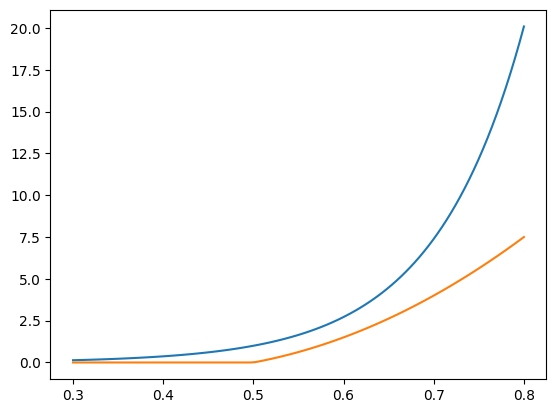

In [25]:
import matplotlib.pyplot as plt
import numpy as np

vth = 0.5
beta = 0.1
x = np.linspace(vth-0.2,vth+0.3, 100)
v = (x-vth)/beta
y = np.exp(v)
y2 = np.maximum(0, v+v**2/2) # piecewise
plt.plot(x, y, label="exponential")
plt.plot(x, y2, label="piecewise linear")
plt.show()


In [26]:
y.min()

0.1353352832366127

# Laplacian-Tree

## Low level

In [1]:
import torch
torch.backends.cuda.preferred_linalg_library()

/root/miniconda3/envs/EP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<_LinalgBackend.Default: 0>

In [31]:
w = torch.randn(3, 4).clamp_min(0.01)

In [32]:
Ll = torch.concat([torch.diag(w.sum(dim=1)), w.T], dim=0)
Lr = torch.concat((w, torch.diag(w.sum(dim=0))), dim=0)
L = torch.concat((Ll, Lr), dim=1)

In [33]:
Lp = L+torch.eye(7)*1e-5

In [34]:
c_2 = torch.linalg.cholesky(Lp)

In [35]:
c_1, info1 = torch.linalg.cholesky_ex(L)

In [36]:
c_3 ,info2 = torch.linalg.cholesky_ex(Lp)

In [42]:
info1.item() ==7

True

In [47]:
c_3

tensor([[ 0.5350,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.7685,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.5589,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.4789,  0.0130,  0.0179,  0.2154,  0.0000,  0.0000,  0.0000],
        [ 0.0187,  0.7295,  0.0179, -0.0871,  0.2006,  0.0000,  0.0000],
        [ 0.0187,  0.0130,  0.1192, -0.0523, -0.0824,  0.2498,  0.0000],
        [ 0.0187,  0.0130,  0.4038, -0.0759, -0.1181, -0.2497,  0.0084]])

In [44]:
torch.allclose(c_2, c_3)

True

In [45]:
abs(c_3-c_2).max()

tensor(0.)

In [41]:
cond = torch.linalg.cond(Lp)

In [42]:
cond

tensor(114481.3125)

## Sparsifier

### CNN

In [1]:
import torch
import torch.nn as nn

x = torch.rand(1, 1, 8, 8) # batch size, channels, height, width

l1 = nn.Conv2d(1, 3, 3, 1, bias=False) # in_channels, out_channels, kernel_size, stride

/root/miniconda3/envs/EP/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def conv2d(x, w):
    return torch.einsum('bchw, oihw -> bco', x, w)

In [4]:
l1.weight.shape

torch.Size([3, 1, 3, 3])

## Laplacian.jl

In [3]:
import julia
from julia import Base

julia.install()
j = julia.Julia()
j.using("LinearAlgebra")


FileNotFoundError: [Errno 2] No such file or directory: 'julia'